# RETO REGRESIÓN

**Santiago Velásquez Hernández (CC. 1.036.647.710; santiago.velasquez4@udea.edu.co)**

**Carolina González Marín (CC. 1.017.251.647; carolina.gonzalezm1@udea.edu.co)**

In [1]:
import os
from functools import partial
import joblib
import data
import metrics

import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import requests
import json

In [2]:
def evaluate_model(*, model, metric, X_train, y_train, X_test, y_test):
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    train_error = metric(y_train, train_predictions)
    test_error = metric(y_test, test_predictions)
    return {
        "train_predictions": train_predictions,
        "test_predictions": test_predictions,
        "train_error": train_error,
        "test_error": test_error
    }

def print_report(*, model, evaluation):
    print(f"Model used:\n\t{reg}")
    print(f"Error:\n\ttrain set {evaluation['train_error']}\n\ttest error: {evaluation['test_error']}")

In [3]:
train = pd.read_csv("./data/train_regression.csv")

In [4]:
# Partición del conjunto de datos

dataset_path = "./data/train_regression.csv"
data = data.get_dataset(
    partial(pd.read_csv, filepath_or_buffer=dataset_path),
    splits=("train", "test")
)
data

{'train': (     age     sex     bmi children smoker     region
  585   41    male  28.405        1     no  northwest
  765   51    male  37.000        0     no  southwest
  577   47    male  29.800        3    yes  southwest
  247   27  female  21.470        0     no  northwest
  452   50  female  27.830        3     no  southeast
  ..   ...     ...     ...      ...    ...        ...
  715   51  female  21.560        1     no  southeast
  767   53    male  34.105        0    yes  northeast
  72    35    male  17.860        1     no  northwest
  235   62    male  37.400        0     no  southwest
  37    31  female  25.740        0     no  southeast
  
  [627 rows x 6 columns],
  585     6664.68595
  765     8798.59300
  577    25309.48900
  247     3353.47030
  452    19749.38338
            ...     
  715     9855.13140
  767    43254.41795
  72      5116.50040
  235    12979.35800
  37      3756.62160
  Name: y, Length: 627, dtype: float64),
 'test': (     age     sex     bmi childre

# Análisis Exploratorio de Datos

Queremos realizar un modelo de predicción de seguros médicos en función de ciertas características que se verán más adelante. Para esto, se realiza una exploración inicial de los datos para hacernos una idea de la apariencia y estructura de los mismos de forma que se pueda realizar el modelo. 

In [5]:
# Visualización del conjunto de datos

print('DATASET')
print(train)

DATASET
     age     sex     bmi  children smoker     region            y
0     43  female  25.080         0     no  northeast   7325.04820
1     39    male  35.300         2    yes  southwest  40103.89000
2     45  female  30.495         1    yes  northwest  39725.51805
3     19  female  32.900         0     no  southwest   1748.77400
4     60    male  39.900         0    yes  southwest  48173.36100
..   ...     ...     ...       ...    ...        ...          ...
891   18  female  31.350         4     no  northeast   4561.18850
892   39  female  23.870         5     no  southeast   8582.30230
893   58    male  25.175         0     no  northeast  11931.12525
894   37  female  47.600         2    yes  southwest  46113.51100
895   55    male  29.900         0     no  southwest  10214.63600

[896 rows x 7 columns]


In [6]:
# Información tipo de variable 

print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 896 entries, 0 to 895
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       896 non-null    int64  
 1   sex       896 non-null    object 
 2   bmi       896 non-null    float64
 3   children  896 non-null    int64  
 4   smoker    896 non-null    object 
 5   region    896 non-null    object 
 6   y         896 non-null    float64
dtypes: float64(2), int64(2), object(3)
memory usage: 49.1+ KB
None


Dándole un vistazo general a las variables incluidas en el conjunto de datos, estas se clasifican en tres categorías de acuerdo a su tipo: 
- **Variables categóricas dummy** (donde el valor de la observación pertenece a una de dos categorías).
- **Variables categóricas multiclase**
- **Variables numéricas**

In [7]:
#Variables según su tipo

dummy = ['sex', 'smoker']
multiclass = ['region']
numerics = ['bmi','age','children']

<AxesSubplot:>

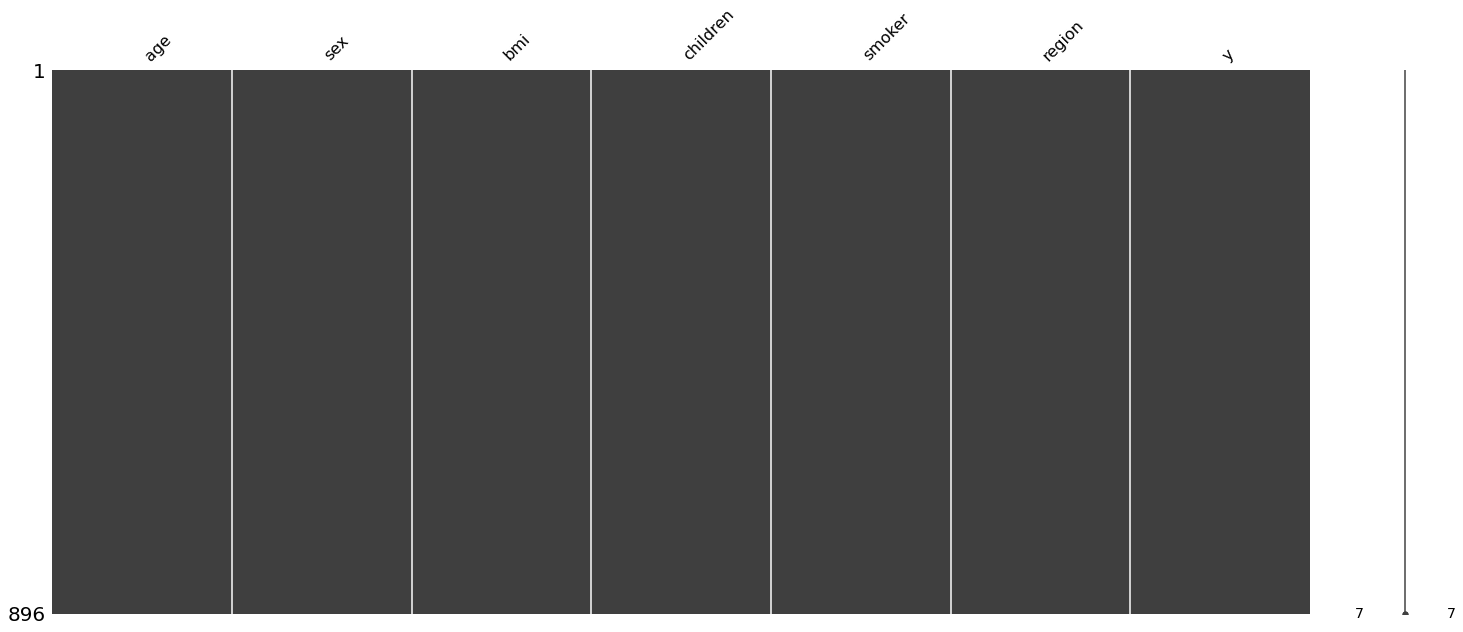

In [8]:
#Valores nulos en conjunto de datos

msno.matrix(train)

Como se puede visualizar en la gráfica anterior, no se observa la presencia de valores nulos en la base de datos. Ahora realizaremos algunas observaciones en cada uno de los tipos de variables.

## Variables Categóricas

In [9]:
#Análisis de Frecuencias para cada una de las variables del conjunto de datos

n_entr = len(train)

for col in dummy:
    print('Variable: {}'.format(col))
    print('---------------------------------------------------------------')
    s = train[col].value_counts()
    for index, value in s.items():
        print("Categoría : {}, Nro. observaciones : {}, %: {:2f}".format(index,value,value*100/n_entr))
    print('\n')

Variable: sex
---------------------------------------------------------------
Categoría : male, Nro. observaciones : 459, %: 51.227679
Categoría : female, Nro. observaciones : 437, %: 48.772321


Variable: smoker
---------------------------------------------------------------
Categoría : no, Nro. observaciones : 708, %: 79.017857
Categoría : yes, Nro. observaciones : 188, %: 20.982143




In [11]:
#Análisis de Frecuencias para cada una de las variables categóricas multiclase 
#del conjunto de datos

n_entr = len(train)
for col in multiclass:
    print('Variable: {}'.format(col))
    print('---------------------------------------------------------------')
    #print('ENTRENAMIENTO')
    s = train[col].value_counts()
    for index, value in s.items():
        print("Categoría : {}, Nro. observaciones : {}, %: {:2f}".format(index,value,value*100/n_entr))
    print('\n')

Variable: region
---------------------------------------------------------------
Categoría : northeast, Nro. observaciones : 230, %: 25.669643
Categoría : southeast, Nro. observaciones : 229, %: 25.558036
Categoría : northwest, Nro. observaciones : 226, %: 25.223214
Categoría : southwest, Nro. observaciones : 211, %: 23.549107




Al observar la frecuencia de los valores que toman las variables categóricas dummy y multiclase se puede evidenciar que la distribución de las categorías de las variables está balanceada, lo que sugiere que se hará buena partición de los datos originales (en entrenamiento y testeo) y seguramente puede llegar a evitar problemas al momento de generalizar los modelos considerando el balanceo que se observa a simple vista.

<AxesSubplot:xlabel='region', ylabel='y'>

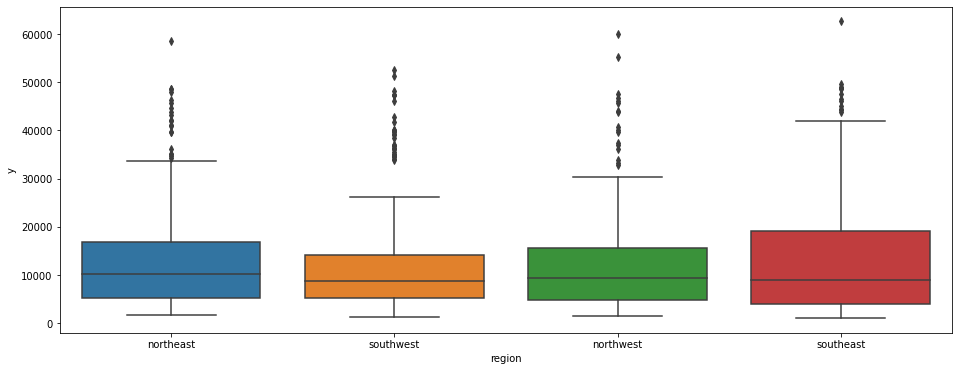

In [12]:
plt.figure(figsize=(16, 6))
sns.boxplot(x='region',y='y',data=train)

<AxesSubplot:xlabel='sex', ylabel='y'>

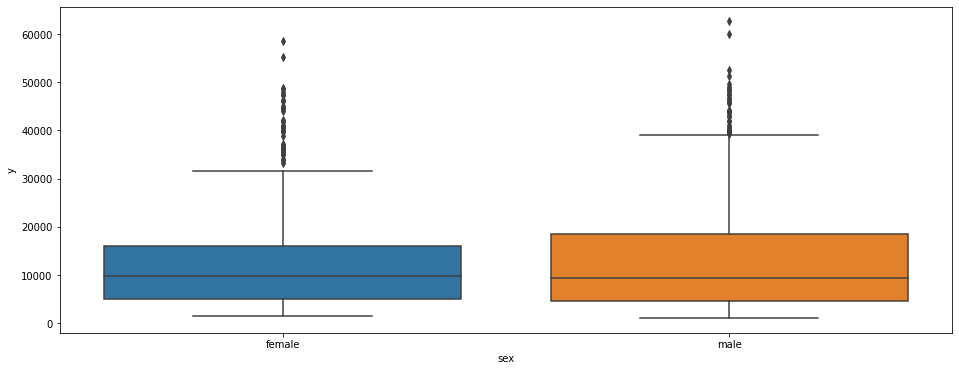

In [13]:
plt.figure(figsize=(16, 6))
sns.boxplot(x='sex',y='y',data=train)

<AxesSubplot:xlabel='smoker', ylabel='y'>

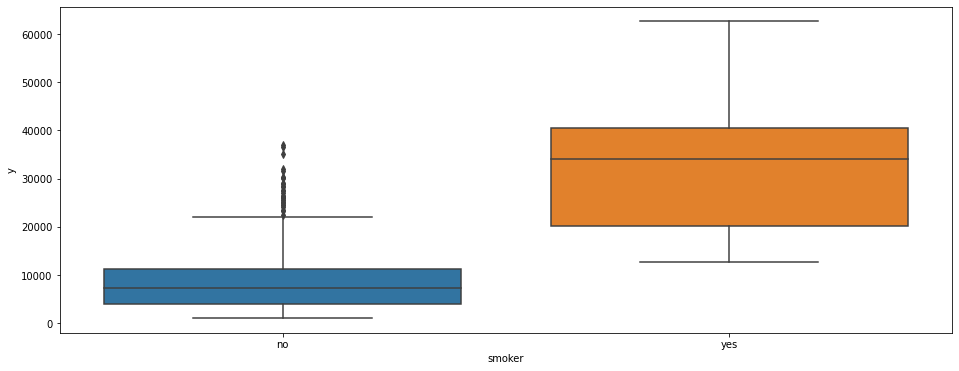

In [14]:
plt.figure(figsize=(16, 6))
sns.boxplot(x='smoker',y='y',data=train)

Aparentemente en la región y el sexo no serían un buen diferenciador para estimar el precio del seguro médico debido a que, a simple vista, los diagramas de boxplot muestran una tendencia similar para cada una de las categorías que toman estas variables para el conjunto de datos.

Sin embargo, para la variable *smoker*, se observa que el precio del seguro médico tiende a ser más alto para personas fumadoras. 

## Variables Numéricas

In [15]:
#Exploración de valores en las variables numéricas del conjunto de datos

for col in numerics:  
    print('Variable: {}'.format(col)) 
    print('-------------------')
    print('Valores: {}'.format(train[col].unique()))
    print('\n')

Variable: bmi
-------------------
Valores: [25.08  35.3   30.495 32.9   39.9   35.6   26.8   35.4   39.93  34.1
 26.6   33.33  33.66  30.97  29.355 28.785 24.225 40.375 22.705 29.7
 30.115 22.135 50.38  29.735 31.    24.89  33.535 30.78  31.4   29.45
 43.01  18.3   37.335 33.63  24.605 25.74  31.6   30.2   36.86  29.3
 34.96  36.575 30.59  28.215 36.48  30.4   43.4   41.91  31.73  39.6
 35.8   39.1   26.315 40.66  30.875 34.4   36.1   26.695 28.88  25.46
 29.48  27.28  24.32  41.14  38.39  39.425 17.86  32.78  19.8   42.24
 27.455 23.465 21.7   33.    33.44  24.7   31.065 37.1   28.595 32.775
 31.79  23.655 35.91  24.86  23.18  27.72  34.77  28.4   27.5   36.955
 32.965 26.73  35.75  28.1   38.    39.995 37.3   21.85  37.73  26.18
 23.7   26.41  36.19  28.38  32.3   34.105 27.36  29.83  32.8   34.43
 28.12  20.79  35.2   19.19  19.95  26.22  21.945 22.3   31.24  29.26
 25.84  38.94  36.67  23.54  24.6   25.175 26.885 47.74  25.8   41.325
 20.9   31.255 28.    35.72  38.28  40.26  32.7 

La variable *children* es una variable numérica discreta, por lo que se considerará esta como una variable categórica para osbervar su frecuencia

In [19]:
#Definición de las variables teniendo en cuenta la consideración anterior

numerics = ['bmi','age']
multiclass = ['region', 'children']

In [20]:
#Cambio de tipo para variable 'children' en ambos conjuntos de datos

train['children'] = train['children'].astype(str)

In [21]:
#Análisis de Frecuencias para la variable children

children = ['children']
for col in children:
    print('Variable: {}\n'.format(col))
    
    s = train[col].value_counts()
    for index, value in s.items():
        print("Categoría : {}, Nro. observaciones : {}, %: {:2f}".format(index,value,value*100/n_entr))
    print('\n')

Variable: children

Categoría : 0, Nro. observaciones : 383, %: 42.745536
Categoría : 1, Nro. observaciones : 217, %: 24.218750
Categoría : 2, Nro. observaciones : 160, %: 17.857143
Categoría : 3, Nro. observaciones : 107, %: 11.941964
Categoría : 4, Nro. observaciones : 18, %: 2.008929
Categoría : 5, Nro. observaciones : 11, %: 1.227679




<AxesSubplot:xlabel='children', ylabel='y'>

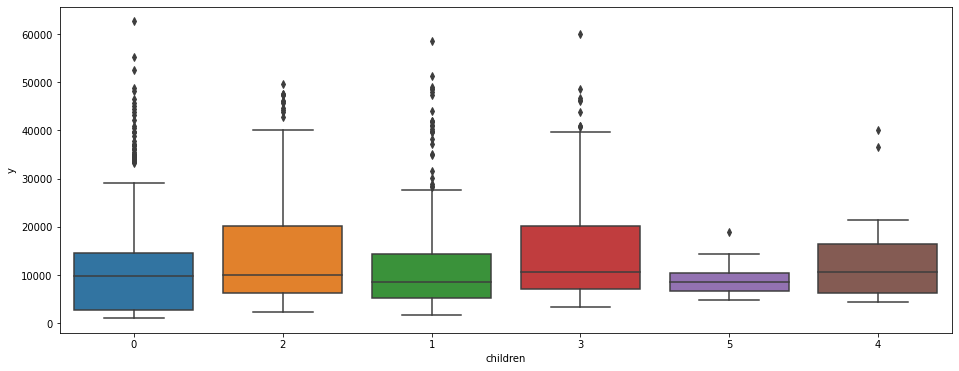

In [22]:
plt.figure(figsize=(16, 6))
sns.boxplot(x='children',y='y',data=train)

Aparentemente, el número de hijos tampoco sería un buen determinante del precio de un seguro médico si visualizamos el diagrama de boxplot.

              bmi         age
count  896.000000  896.000000
mean    30.542617   39.234375
std      5.984036   14.212151
min     15.960000   18.000000
25%     26.272500   27.000000
50%     30.230000   39.000000
75%     34.488750   52.000000
max     53.130000   64.000000


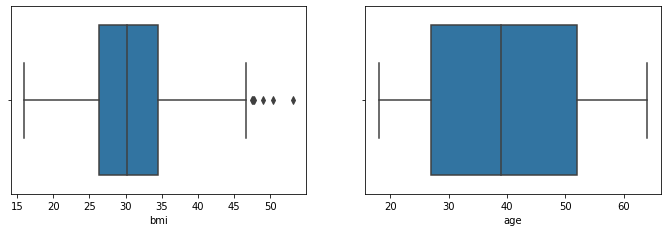

In [23]:
print(train[numerics].describe())
plt.figure(figsize=(18,20))
for i, var in enumerate(numerics):
    plt.subplot(5,3,i+1)
    sns.boxplot(x=train[var])

Las personas que se tienen para el conjunto de datos se encuentran entre los 18 y los 64 años de edad.

Consideremos los siguientes rangos de índice de masa corporal para interpretar mejor los resultados:
- **Bajo peso**: Por debajo de 18.5
- **Normal**: 18.5-24-9
- **25.0-29.9**: Sobrepeso
- **30.0 o más**: Obeso


En cuanto a la descripción de las variables numéricas se puede observar que el *bmi* medio es de 30.54, un valor bastante alto considerando los valores normales de nivel de peso. Adicionalmente, el percentil 50 muestra que más de la mitad de las personas de la base de datos son obesas y que menos del 25% de las personas se encuentran en un rango normal de peso. 

Esto podría generar que los datos se encuentren sesgados a cierta población en particular, sin embargo, para la base de datos de testeo, se observa que el comportamiento es similar por la tendencia de obesidad en las personas. Seguramente el modelo no se puede generalizar con una población con características diferentes a las observadas en el conjunto de ambas bases de datos.

<Figure size 1152x432 with 0 Axes>

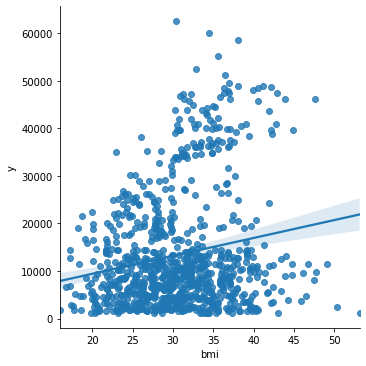

In [24]:
plt.figure(figsize=(16, 6))
sns.lmplot(x='bmi',y='y',data=train)

<Figure size 1152x432 with 0 Axes>

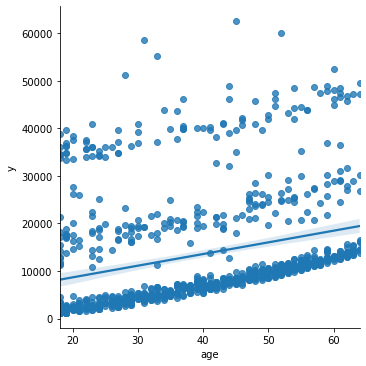

In [25]:
plt.figure(figsize=(16, 6))
sns.lmplot(x='age',y='y',data=train)

<AxesSubplot:xlabel='age', ylabel='y'>

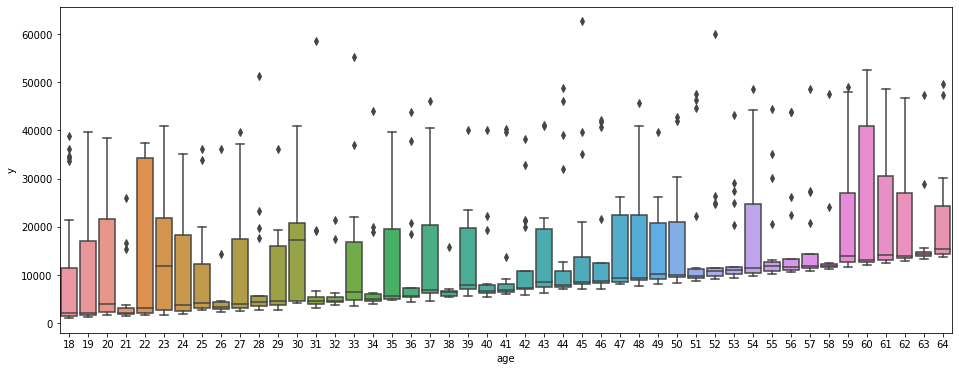

In [26]:
plt.figure(figsize=(16, 6))
sns.boxplot(x='age',y='y',data=train)

Las gráficas muestran una tendencia para ambas variables numéricas. A medida que aumenta la edad o el *ibm*, aumentan los precios de los seguros médicos. A pesar de esto, se observa que hay una gran dispersión en los datos lo que se ve reflejado en la presencia de valores atípicos. 

Adicionalmente, para la edad, se observa una aparente partición lineal en 3 grupos.

### Matriz de Correlación de Variables

Ahora realicemos el cambio de valores en las variables categóricas binarias para pasarlas a variables categóricas dummy y hacer un análisis de correlación entre estas variables con la variable objetivo. 

In [27]:
#Cambio de valores "yes" por 1 y "no" por 0 en la variable 'smoker'

smoker = ['smoker']
dummy_dicc = {'yes':1,'no':0}
for col in smoker:
    train[col] = train[col].map(dummy_dicc)

In [28]:
#Cambio de valores "male" por 1 y "female" por 0 en la variable 'sex'

sex = ['sex']
dummy_dicc = {'male':1,'female':0}
for col in sex:
    train[col] = train[col].map(dummy_dicc)

Haremos algo similar para la variable *region*, agregando valores numéricos a la variable con el fin de evidenciar si la región muestra alguna correlación. 

In [29]:
train['region'].unique()

array(['northeast', 'southwest', 'northwest', 'southeast'], dtype=object)

In [30]:
region = ['region_num']
num_dicc = {'northeast':1,'southwest':2,'northwest':3, 'southeast':4}
for col in region:
    train[col] = train['region'].map(num_dicc)
    
train['region_num']=train['region_num'].astype(int)

In [31]:
num_to_dummy = ['children']

In [32]:
train[num_to_dummy] = (train[num_to_dummy].astype(int)>0).astype(int)

In [33]:
variables= ['smoker','age','bmi','sex','children','region_num']

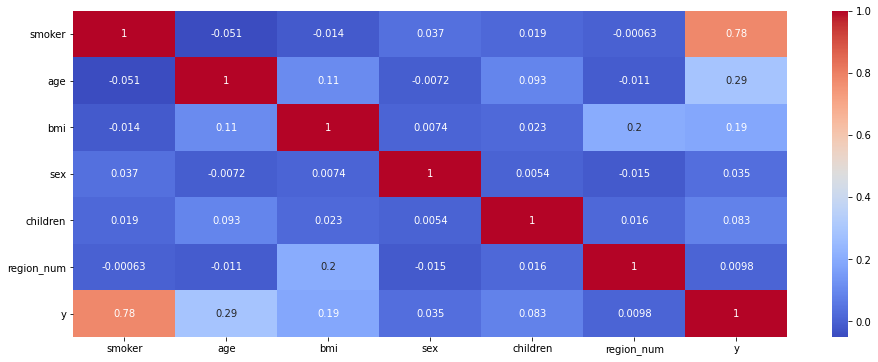

In [34]:
matriz_corr_1 = train[variables + ['y']].corr()
plt.figure(figsize=(16,6))
sns.heatmap(matriz_corr_1, cmap="coolwarm",annot=True)
plt.show()

Se observa que la variable con correlación más alta es la variable *smoker*. Por facilidad, esta será la variable que se utilzará para el baseline modelo. Además de esto la variable *age* y *bmi* también muestran una correlación positiva y alta en relación con las otras variables. 

En las otras variables no se observa una posible correlación de las mismas respecto al precio de los seguros médicos, sin embargo, se seguirán teniendo en cuenta para el análisis pues pueden llegar a tener una relación si las analizamos de manera simultánea. 

## Variable Objetivo

count      896.000000
mean     13379.688250
std      12110.713713
min       1121.873900
25%       4819.842913
50%       9556.297050
75%      17092.916520
max      62592.873090
Name: y, dtype: float64


<AxesSubplot:xlabel='y'>

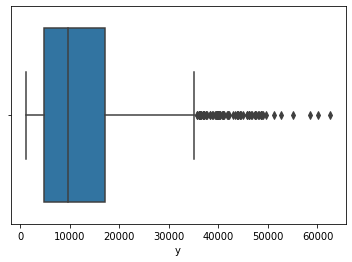

In [35]:
print(train['y'].describe())
sns.boxplot(x=train['y'])

La media del costo de los seguros médicos es de 13.379, con un valor máximo de 62.592 y un mínimo de 1.121. Sin embargo, casi la totalidad de los precios del seguro médico se encuentran por debajo de los 35.000.

# Modelos

## Baseline:

Para el Baseline, como se mencionó con anterioridad, se tendrá en cuenta que aparentemente la variable que tiene mayor correlación según el análisis exploratorio de los datos es la variable *smoker*. Calcularemos entonces el promedio del precio del seguro médico a partir de esta variable para nuestro primer modelo.

In [36]:
model_path = os.path.join("models", "baseline", "model.joblib")
reg = joblib.load(model_path)

evaluation = evaluate_model(
    model = reg,
    metric = metrics.custom_error,
    X_train = data["train"][0],
    y_train = data["train"][1],
    X_test = data["test"][0],
    y_test = data["test"][1]
)

print_report(model=reg, evaluation=evaluation)

Model used:
	Pipeline(steps=[('avarage-baseline', AverageYSmokerRegressor())])
Error:
	train set 6126.26705700578
	test error: 5905.373903078753


De igual forma, a pesar de que la correlación en esta variable fue alta, se debe tener en cuenta que la variable es de tipo binaria y se están dejando por fuera el resto de los factores que pueden llegar a afectar el precio del seguro médico. 

## Linear Regression Model:

In [37]:
model_path = os.path.join("models", "linear_regressor", "model.joblib")
reg = joblib.load(model_path)
evaluation = evaluate_model(
    model=reg,
    metric=metrics.custom_error,
    X_train=data["train"][0],
    y_train=data["train"][1],
    X_test=data["test"][0],
    y_test=data["test"][1]
)
print_report(model=reg, evaluation=evaluation)

Model used:
	Pipeline(steps=[('average-price-extractor', AverageYSmokerExtractor()),
                ('categorical-encoder',
                 CategoricalEncoder(force_dense_array=True, one_hot=True)),
                ('standard-scaler', StandardScaler()),
                ('linear-regressor', LinearRegression())])
Error:
	train set 6140.909618794448
	test error: 6028.035012451037


## Linear regression with Feature Engineering:

In [38]:
model_path = os.path.join("models", "feature_engineering", "model.joblib")
reg = joblib.load(model_path)
evaluation = evaluate_model(
    model=reg,
    metric=metrics.custom_error,
    X_train=data["train"][0],
    y_train=data["train"][1],
    X_test=data["test"][0],
    y_test=data["test"][1]
)
print_report(model=reg, evaluation=evaluation)

Model used:
	Pipeline(steps=[('average-price-extractor', AverageYSmokerExtractor()),
                ('categorical-encoder',
                 CategoricalEncoder(force_dense_array=True)),
                ('crosser', PolynomialFeatures()),
                ('standard-scaler', StandardScaler()),
                ('linear-regressor', LinearRegression())])
Error:
	train set 5964.333468496456
	test error: 5912.494426542673


## Bagging Regressor

In [92]:
model_path = os.path.join("models", "bagging_regressor", "model.joblib")
reg = joblib.load(model_path)
evaluation = evaluate_model(
    model=reg,
    metric=metrics.custom_error,
    X_train=data["train"][0],
    y_train=data["train"][1],
    X_test=data["test"][0],
    y_test=data["test"][1]
)
print_report(model=reg, evaluation=evaluation)

Model used:
	Pipeline(steps=[('categorical-encoder',
                 CategoricalEncoder(force_dense_array=True)),
                ('crosser', PolynomialFeatures()),
                ('standard-scaler', StandardScaler()),
                ('bagging', BaggingRegressor())])
Error:
	train set 5445.209925259636
	test error: 5840.519395252482
/home/sant_vel/anaconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator OrdinalEncoder from version 0.24.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/sant_vel/anaconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator ColumnTransformer from version 0.24.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/sant_vel/anaconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator Pol

## Gradient Boosting Regressor

In [93]:
model_path = os.path.join("models", "gradient_boosting_regressor", "model.joblib")
reg = joblib.load(model_path)
evaluation = evaluate_model(
    model=reg,
    metric=metrics.custom_error,
    X_train=data["train"][0],
    y_train=data["train"][1],
    X_test=data["test"][0],
    y_test=data["test"][1]
)
print_report(model=reg, evaluation=evaluation)

Model used:
	Pipeline(steps=[('categorical-encoder',
                 CategoricalEncoder(force_dense_array=True)),
                ('crosser', PolynomialFeatures()),
                ('standard-scaler', StandardScaler()),
                ('gradient', GradientBoostingRegressor(presort=None))])
Error:
	train set 5497.339437739069
	test error: 5762.867552635695
/home/sant_vel/anaconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator OrdinalEncoder from version 0.24.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/sant_vel/anaconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator ColumnTransformer from version 0.24.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/sant_vel/anaconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to 

## Random Forest Regressor

In [94]:
model_path = os.path.join("models", "random_forest", "model.joblib")
reg = joblib.load(model_path)
evaluation = evaluate_model(
    model=reg,
    metric=metrics.custom_error,
    X_train=data["train"][0],
    y_train=data["train"][1],
    X_test=data["test"][0],
    y_test=data["test"][1]
)
print_report(model=reg, evaluation=evaluation)

/home/sant_vel/anaconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator KBinsDiscretizer from version 0.24.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/sant_vel/anaconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator ColumnTransformer from version 0.24.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/sant_vel/anaconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator OrdinalEncoder from version 0.24.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/sant_vel/anaconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator PolynomialFeatures from version 0.24.1 when using version 0.23.1. Thi

## Decision Tree Regressor

In [95]:
model_path = os.path.join("models", "decision_tree", "model.joblib")
reg = joblib.load(model_path)
evaluation = evaluate_model(
    model=reg,
    metric=metrics.custom_error,
    X_train=data["train"][0],
    y_train=data["train"][1],
    X_test=data["test"][0],
    y_test=data["test"][1]
)
print_report(model=reg, evaluation=evaluation)

/home/sant_vel/anaconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator KBinsDiscretizer from version 0.24.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/sant_vel/anaconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator ColumnTransformer from version 0.24.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/sant_vel/anaconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator OrdinalEncoder from version 0.24.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/sant_vel/anaconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator PolynomialFeatures from version 0.24.1 when using version 0.23.1. Thi

# Hipótesis de Error 

## Valores Atípicos

Es bien sabido que los valores atípicos requieren de un pretratamiendo debido a que pueden sesgar el modelo, por lo tanto, sería pertinente que se crearán variables nuevas que tengan las correcciones adecuadas de estos valores.

Si observamos en el análisis exploratorio, para las variables en donde había presencia de outliers, todos tendían a estar por encima, lo que se puede ver reflejado en una sobreestimación del costo del seguro médico. 

Para el tratamiento de datos atípicos podría usarse el método del Rango Intercuantil, donde, una vez identificados los datos atípicos, estos serían reemplazados por el máximo o el mínimo de los datos sin outliers y posteriormente guardados en una variable nueva. El rango intercuantil se calcularía con los datos de entrenamiento y sería utilizado tanto en el conjunto de datos de entrenamiento como en el de testeo para encontrar los outliers.

## Valores por Defecto en los Modelos

Para todos los modelos utilizados, se utilizaron los valores por defecto que tenía el modelo de regresión. Sería importante revisar cada uno de los parámetros del modelo con el fin de escoger los valores más adecuados para el conjunto de datos que se está trabajando.

## One Hot Encoding

Al ensayar varios modelos, se observa que discretizar las características no tiende a mejorarlo. Al igual que como se realizó para el análisis exploratorio, podríamos hacer One-Hot-Encoding en el modelo en las variables binarias para facilitar el análisis. Adicionalmente, se podrían discretizar las variables numéricas de forma que se pueda hacer también one-hot-encoding con las mismas; sin embargo, valdría la pena realizar un análisis exploratorio más profundo de los datos de forma que las variables utilizadas puedan ser discretizadas de la mejor manera. 

# Envío de Reporte

In [110]:
nombres = "Santiago Velásquez Hernández, CC. 1036647710; Carolina González Marín, CC. 1017251647"
mails = "carolina.gonzalezm1@udea.edu.co"
URL = "https://qzbbjszmjk.execute-api.us-east-1.amazonaws.com/dev"

In [97]:
X_test_regression = pd.read_csv("./data/test_regression_students.csv")

In [ ]:
X_test_regression

In [105]:
X_test_regression['children'] = X_test_regression['children'].astype(str)

In [107]:
y_pred_regression = list(reg.predict(X_test_regression))

In [111]:
results = {"id": nombres ,"email": mails, "task_type": "Regression" ,"predictions": y_pred_regression}
headers = {'Content-type': 'application/json', 'Accept': 'text/plain'}

In [116]:
# Descomentar solo para envio de reporte 

#r = requests.post(url= URL+"/benchmarkin/", data = json.dumps(results) , headers=headers)

In [118]:
r.text

'{"MAE":6056.260821108606}'